In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Add
import numpy as np
from scipy import stats
from datetime import datetime
import pandas as pd
from plotnine import ggplot, geom_point, aes, scale_shape_manual, geom_vline
from plotnine import scale_x_continuous, scale_y_continuous, theme

# Set directory to output training results.
bp = '/home/ubuntu/'

Set data parameters and hyperparameters.

In [2]:
rcn = 0.1
margin = 0.5
lr = 1e-2
sample_size = 20000 
width = 1e3
activation = 'leaky'
init_sd = 1/(width**0.5)
# init_sd = 1/(width)
use_bias_inner = False
use_bias_outer = False
trainable_outer = False
train_batch_size = 1
epochs = 1

# Prepare filename prefix for exporting CSV of results and h5 model files
date = datetime.now().strftime("%Y-%m-%d_%H%M%S")

# Use a suggestive description based on whatever hyperparam choices
# you are making.  You want to be able to filter filenames in 
# the directory to search for the given experiment for plotting later on.
experiment_description = 'onelayerfc' + str(int(width)) + '_rcn' + str(rcn)
base_filestring = date + '_' + experiment_description

Set experimental parameters.

In [3]:
'''Simple experiment setup -- use on first try
This will do optlin=0.4, 0.25, 0.1, with 4 different init's each'''
num_runs_per_error = 4
num_optlin = 3

'''Paper experiment setup -- parameters used to create figures in paper
This will do 25 equally spaced optlin between 0.1 & 0.4,
with 10 different weight inits per optlin.'''
# num_runs_per_error = 10
# num_optlin = 25

# Use different seeds for first layer weight initialization
seeds = 100 * (np.arange(num_runs_per_error) + 1)

# Consider optlin in an equally spaced grid from 0.4 to 0.1
errors = np.linspace(0.4, 0.1, num = num_optlin)

First create a special layer class for using the +/- constant outer layer initialization.

In [4]:
# Create outer layer initializer of all +/- constant.
class UniformPlusMinusConstant(keras.initializers.Initializer):
    def __init__(self, const, seed = None):
        self.const = tf.constant(const, dtype = keras.backend.floatx())
        self.seed = seed
    def __call__(self, shape, dtype=None):
        k = int(shape[0] / 2) 
        if shape[0] % 2 == 0:
            return self.const * tf.concat([tf.constant(1.0, shape = (k,1)), tf.constant(-1.0, shape = (k,1))], axis = 0)
        else:
            return self.const * tf.concat([tf.constant(1.0, shape = (k+1,1)), tf.constant(-1.0, shape = (k,1))], axis = 0)
    def get_config(self):  # To support serialization
        return {'const': self.const}


Create a neural network model class to be used.

In [5]:
def one_hlayer_learner(d, # Input dimension
                       m, # Width of network
                       activation = 'leaky', # Either leaky, relu, tanh, sigmoid, elu 
                       init_sd = 0.001, # Initialization SD for std normal initializer
                       use_bias_inner = False,
                       use_bias_outer = False,
                       trainable_outer = False, 
                       seed = 123): # Seed for random initialization of weights
    inputs = Input(shape = (d,), name = 'input')
    if activation == 'leaky':
        x = Dense(m, 
                  kernel_initializer = keras.initializers.RandomNormal(stddev = init_sd, seed = seed),
                  activation = None, 
                  use_bias = use_bias_inner)(inputs)
        x = LeakyReLU(alpha = 0.1)(x)
    else:
        x = Dense(m, 
                  kernel_initializer = keras.initializers.RandomNormal(stddev = init_sd, seed = seed),
                  activation = activation, 
                  use_bias = use_bias_inner)(inputs)
    output = Dense(1, 
                   kernel_initializer = UniformPlusMinusConstant(1.0/np.sqrt(m), seed),
                   activation = 'linear', 
                   use_bias = use_bias_outer,
                   trainable = trainable_outer)(x)
    return keras.Model(inputs = inputs, outputs = output)

Create the dataset $\mathcal{D}_{\gamma_0, b}$.

In [6]:
def prep_dataset(n_train, x_loc = 3.0, margin = 0.0, rcn = 0.0, boundary_factor = 1.75, seed = 123):
    # Set seed for data
    np.random.seed(seed)
    n_per_class = int(n_train // 2)
    # Create two clusters of data, centered at (+/- x_loc, 0)
    clust1 = np.random.normal(loc = (-1*x_loc, 0), size = (n_per_class, 2))
    clust2 = np.random.normal(loc = (x_loc, 0), size = (n_per_class, 2))
    
    # Introduce RCN and deterministic label noise.
    # Ensure that rcn fraction of |x|>b have labels flipped,
    # and that 100% of labels with |x|<b have been flipped.
    
    # Initially make rcn fraction of labels with x>0 have label 0,
    # and rcn fraction of labels with x<0 have label 1.
    flip = int(n_per_class * rcn)
    class1 = np.array([0.0] * (n_per_class - flip) + [1] * flip)
    class2 = np.array([1] * (n_per_class - flip) + [0] * flip)
    
    # Then deterministically set label to 0 if 0<x<b and label to 1 if -b<x<0
    class1[(clust1[:,0] <= boundary_factor) & (clust1[:,0] >= 0)] = 0
    class2[(clust2[:,0] <= boundary_factor) & (clust2[:,0] >= 0)] = 0
    class1[(clust1[:,0] >= -1*boundary_factor) & (clust1[:,0] <= 0)] = 1
    class2[(clust2[:,0] >= -1*boundary_factor) & (clust2[:,0] <= 0)] = 1
    
    # Note that the ordering of the data does not matter here as we will shuffle
    # the data randomly before running SGD.
    
    # Create pandas df for easy plotting later on.
    data = pd.DataFrame.from_dict({
        'x': np.concatenate([clust1[:,0], clust2[:,0]], axis = 0),
        'y': np.concatenate([clust1[:,1], clust2[:,1]], axis = 0),
        'group': np.concatenate([class1, class2])})
    data['group'] = data['group'].astype('category')
    
    # If using a margin, remove all data with |x| < margin.
    if margin > 0:
        data = data[np.abs(data.x) > margin]
    
    # Extract numpy arrays of data to be used for creating tf dataset.
    features = np.array((data.x, data.y)).T
    response = np.array(data.group)
    return data, features, response

Derive formulas for going between the boundary factor $b$ and $\mathsf{OPT}_{\mathsf{lin}}$, and for calculating the Bayes-optimal classifier accuracy.

In [7]:
def error_from_b(boundary_factor, margin = 0.5, rcn = 0.1):
    rcn_error = rcn * stats.norm.cdf(3 - boundary_factor)/ stats.norm.cdf(3 - margin)
    deterministic_error = (stats.norm.cdf(3-margin) - stats.norm.cdf(3 - boundary_factor) )/ stats.norm.cdf(3 - margin)
    return rcn_error + deterministic_error

def b_from_error(error, margin = 0.5, rcn = 0.1):
    Z = stats.norm.cdf(3 - margin)
    return 3 - stats.norm.ppf( (1 - error)*Z/(1 - rcn))

def best_classifier_error(boundary_factor, margin = 0.5, rcn = 0.1):
    rcn_error = rcn * stats.norm.cdf(3 - boundary_factor)/ stats.norm.cdf(3 - margin)
    return rcn_error


Visualize the dataset to make sure everything looks alright.  Note: this uses the Python library `plotnine`, which mimics `ggplot2` behavior from R. Note: comment this out if you are running this as a Python script.

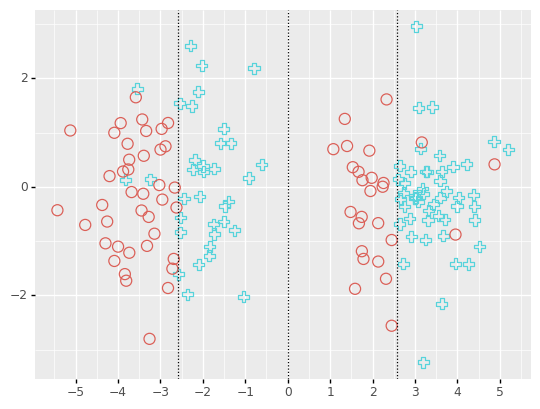

<ggplot: (-9223363243025991918)>

In [8]:
to_plot = 150
margin = 0.5
x_loc = 3
rcn = 0.1
optlin = 0.4
boundary_factor = b_from_error(optlin)

train, _, _ = prep_dataset(to_plot, margin = margin, x_loc = x_loc, rcn = rcn, boundary_factor = boundary_factor)
(ggplot(train,
       aes(x = 'x', y = 'y', color = 'group', shape = 'group')) 
        + geom_point(size = 4, fill = 'none') 
        + scale_shape_manual(values = ('o', 'P')) 
        + geom_vline(xintercept = [-1*boundary_factor, 0, boundary_factor], linetype = 'dotted')
        + scale_x_continuous(breaks = np.arange(-6, 7, 1), name = '') 
        + scale_y_continuous(name = '') 
        + theme(legend_position='none')
)


Create a function which runs the experiment for a given learner and hyperparameter configuration. 

In [9]:
def experiment(learner, n_train, optlin, rcn, 
               lr = 1e-2, train_batch_size = 1, epochs = 1, data_seed = 123,
               filestring = 'na', sgd_shuffle_seed = 123):
    boundary_factor = b_from_error(optlin)
    
    # Note that training batch size is important as it influences learned model.
    # For online SGD, we use batch size 1 and 1 epoch.
    # Validation and test batch size don't matter since we only want to compute summary stats.
    valid_batch_size = 1000 
    n_validation = 1e4
    test_batch_size = valid_batch_size
    n_test = 1e5

    # Create training data.  Note use of data_seed ensure consistent training set across experiments.
    train, train_features, train_response = prep_dataset(
        n_train, margin = margin, x_loc = 3.0, rcn = rcn, boundary_factor = boundary_factor, seed = data_seed)
    train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_response))
    
    # Note: be sure to use shuffle with buffer size > n_train, so that we are 
    # randomly shuffling the data.
    
    # Also of note: we are seeding the shuffle here, so every time experiment() is called,
    # we will use an ordering of the data determined by this seed.  This is important for online SGD.
    train_dataset = train_dataset.batch(train_batch_size).shuffle(buffer_size = 2 * n_train, seed = sgd_shuffle_seed)
    train_loss_metric = keras.metrics.BinaryCrossentropy(from_logits = True)
    train_acc_metric = keras.metrics.BinaryAccuracy()

    # Create validation data.  Note use of data_seed+1.
    valid, valid_features, valid_response = prep_dataset(
        n_validation, margin = margin, x_loc = 3.0, rcn = rcn, boundary_factor = boundary_factor, seed = data_seed + 1)
    valid_dataset = tf.data.Dataset.from_tensor_slices((valid_features, valid_response))
    valid_dataset = valid_dataset.batch(valid_batch_size)
    valid_loss_metric = keras.metrics.BinaryCrossentropy(from_logits = True)
    valid_acc_metric = keras.metrics.BinaryAccuracy()

    # Prepare optimizer, model, and loss
    optimizer = keras.optimizers.SGD(learning_rate = lr)
    loss_fn = keras.losses.BinaryCrossentropy(from_logits = True)
    student = learner

    # Prepare arrays for saving model outputs
    train_loss = list()
    valid_loss = list()
    train_acc = list()
    valid_acc = list()

    # Begin model training
    eval_every_steps = 100
    best_model = student
    best_valid_acc = 0.0
    for epoch in range(epochs):
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                logits = student(x_batch_train, training=True)
                loss_value = loss_fn(y_batch_train, logits)
            grads = tape.gradient(loss_value, student.trainable_weights)
            optimizer.apply_gradients(zip(grads, student.trainable_weights))
            # Update MSE metric
            train_loss_metric.update_state(y_batch_train, logits)
            train_acc_metric.update_state(y_batch_train, logits)

            # Run evaluation metrics after eval_every_steps gradient updates
            if step % eval_every_steps == 0:
                train_loss_result = train_loss_metric.result()
                train_loss_metric.reset_states()
                train_loss.append(train_loss_result.numpy())

                train_acc_result = train_acc_metric.result()
                train_acc_metric.reset_states()
                train_acc.append(train_acc_result.numpy())
                # Run validation metrics every gradient update
                for x_batch_valid, y_batch_valid in valid_dataset:
                    valid_output = student(x_batch_valid, training = False)
                    valid_loss_metric.update_state(y_batch_valid, valid_output)
                    valid_acc_metric.update_state(y_batch_valid, valid_output)
                valid_loss_result = valid_loss_metric.result()
                valid_loss_metric.reset_states()
                valid_loss.append(valid_loss_result.numpy())

                valid_acc_result = valid_acc_metric.result()
                valid_acc_metric.reset_states()
                valid_acc.append(valid_acc_result.numpy())
                
                # If the validation accuracy is better, save this model as the best model.
                if valid_acc_result > best_valid_acc:
                    print('Previous best valid accuracy: %.4f, new best valid accuracy: %.4f' % (best_valid_acc, valid_acc_result))
                    best_model = student
                    best_valid_acc = valid_acc_result.numpy()
                    best_step = step
                    train_loss_at_best = train_loss_result.numpy()
                    train_acc_at_best = train_acc_result.numpy()
                    valid_loss_at_best = valid_loss_result.numpy()
                
                print("\nStep %d, train loss: %.4f, train acc: %.4f" % (step, float(train_loss_result),float(train_acc_result)))
                print("Step %d, valid loss: %.4f, valid acc: %.4f" % (step, float(valid_loss_result),float(valid_acc_result)))
                train_loss_metric.reset_states()
                train_acc_metric.reset_states()
        
    # Done with training; create fresh test set and compare performance on test set.
    # Note use of data_seed+2.
    final_test, final_test_features, final_test_response = prep_dataset(
        n_test, margin = margin, x_loc = 3.0, rcn = rcn, boundary_factor = boundary_factor, seed = data_seed + 2)
    final_test_dataset = tf.data.Dataset.from_tensor_slices((final_test_features, final_test_response))
    final_test_dataset = final_test_dataset.batch(test_batch_size)
    final_test_acc_metric = keras.metrics.BinaryAccuracy()
    final_test_loss_metric = keras.metrics.BinaryCrossentropy(from_logits = True)

    for x_batch_test, y_batch_test in final_test_dataset:
        test_output = best_model(x_batch_test, training = False)
        final_test_acc_metric.update_state(y_batch_test, test_output)
        final_test_loss_metric.update_state(y_batch_test, test_output)
    best_acc = final_test_acc_metric.result()
    best_loss = final_test_loss_metric.result()
    out_str = bp + 'weights_' + filestring + '_lr' + str(lr) + '_optlin' + str(optlin) +\
            '_acc%.4f' % best_acc.numpy() + '.h5' 
    best_model.save_weights(out_str)
    print('\nAt best iterate, had the following metrics.')
    print('Valid acc: %.4f, valid loss: %.4f' % (best_valid_acc, valid_loss_at_best))
    print('Best test accuracy: %.4f, best test loss: %.4f' % (best_acc,best_loss))
    return best_acc.numpy(), best_loss.numpy(), best_step, best_valid_acc, valid_loss_at_best

Run the experiment.

In [10]:
# Prepare lists for experiment outputs
seed_list = list()
errors_list = list()
test_acc = list()
test_loss = list()
step = list()
valid_acc = list()
valid_loss = list()

# Begin experiment
for error in errors:
    for seed in seeds:
        print('\n**********************************************')
        print('Running experiment for error %.4f, seed %d' % (error, seed))
        print('**********************************************\n')
        learner = one_hlayer_learner(2, 
                       width, 
                       activation = activation, 
                       init_sd = init_sd, 
                       use_bias_inner = use_bias_inner,
                       use_bias_outer = use_bias_outer,
                       trainable_outer = trainable_outer, 
                       seed = seed)
        filestring = base_filestring + '_seed' + str(seed)
        res = experiment(learner, sample_size, error, rcn, 
                         lr = lr, train_batch_size = train_batch_size, epochs = epochs,
                         data_seed = 123, filestring = filestring, sgd_shuffle_seed = seed + 5)
        
        # Save results into a dataframe, save after every experiment
        test_acc.append(res[0])
        test_loss.append(res[1])
        step.append(res[2])
        valid_acc.append(res[3])
        valid_loss.append(res[4])
        seed_list.append(seed)
        errors_list.append(error)
        boundary_factors = b_from_error(np.array(errors_list))
        best_poss_errors = best_classifier_error(boundary_factors, margin, rcn)
        results = pd.DataFrame({
            'optlin': np.array(errors_list),
            'best_poss': best_poss_errors, 
            'seed': seed_list,
            'test_acc': test_acc,
            'test_loss': test_loss,
            'valid_acc': valid_acc,
            'valid_loss': valid_loss,
            'best_step': step
        })
        results.to_csv(bp + 'results_' + base_filestring + '_lr' + str(lr) + '.csv')




**********************************************
Running experiment for error 0.4000, seed 100
**********************************************

Previous best valid accuracy: 0.0000, new best valid accuracy: 0.5065

Step 0, train loss: 0.7170, train acc: 0.0000
Step 0, valid loss: 0.6742, valid acc: 0.5065

Step 100, train loss: 0.6957, train acc: 0.5400
Step 100, valid loss: 0.6675, valid acc: 0.5065
Previous best valid accuracy: 0.5065, new best valid accuracy: 0.5607

Step 200, train loss: 0.6601, train acc: 0.5500
Step 200, valid loss: 0.6374, valid acc: 0.5607

Step 300, train loss: 0.6607, train acc: 0.5800
Step 300, valid loss: 0.6361, valid acc: 0.5239
Previous best valid accuracy: 0.5607, new best valid accuracy: 0.7231

Step 400, train loss: 0.5912, train acc: 0.6400
Step 400, valid loss: 0.6220, valid acc: 0.7231

Step 500, train loss: 0.6689, train acc: 0.6500
Step 500, valid loss: 0.6240, valid acc: 0.7047

Step 600, train loss: 0.6242, train acc: 0.6700
Step 600, valid loss:


Step 7900, train loss: 0.5600, train acc: 0.6900
Step 7900, valid loss: 0.6230, valid acc: 0.6208

Step 8000, train loss: 0.6649, train acc: 0.6200
Step 8000, valid loss: 0.6201, valid acc: 0.6473

Step 8100, train loss: 0.5825, train acc: 0.6500
Step 8100, valid loss: 0.6218, valid acc: 0.6254

Step 8200, train loss: 0.6241, train acc: 0.6500
Step 8200, valid loss: 0.6205, valid acc: 0.6369

Step 8300, train loss: 0.6788, train acc: 0.6400
Step 8300, valid loss: 0.6207, valid acc: 0.7031

Step 8400, train loss: 0.6258, train acc: 0.6400
Step 8400, valid loss: 0.6207, valid acc: 0.7135

Step 8500, train loss: 0.6128, train acc: 0.6400
Step 8500, valid loss: 0.6206, valid acc: 0.6637

Step 8600, train loss: 0.6059, train acc: 0.6900
Step 8600, valid loss: 0.6203, valid acc: 0.6469

Step 8700, train loss: 0.6467, train acc: 0.5600
Step 8700, valid loss: 0.6213, valid acc: 0.6538

Step 8800, train loss: 0.6249, train acc: 0.6500
Step 8800, valid loss: 0.6202, valid acc: 0.6643

Step 8900


Step 16100, train loss: 0.5934, train acc: 0.6800
Step 16100, valid loss: 0.6206, valid acc: 0.6553

Step 16200, train loss: 0.6381, train acc: 0.6400
Step 16200, valid loss: 0.6203, valid acc: 0.6791

Step 16300, train loss: 0.6185, train acc: 0.6400
Step 16300, valid loss: 0.6205, valid acc: 0.6679

Step 16400, train loss: 0.6003, train acc: 0.6600
Step 16400, valid loss: 0.6206, valid acc: 0.6629

Step 16500, train loss: 0.6104, train acc: 0.6900
Step 16500, valid loss: 0.6209, valid acc: 0.6539

Step 16600, train loss: 0.6219, train acc: 0.6300
Step 16600, valid loss: 0.6212, valid acc: 0.6425

Step 16700, train loss: 0.5886, train acc: 0.6700
Step 16700, valid loss: 0.6227, valid acc: 0.6265

Step 16800, train loss: 0.6730, train acc: 0.6100
Step 16800, valid loss: 0.6224, valid acc: 0.6473

Step 16900, train loss: 0.5833, train acc: 0.7200
Step 16900, valid loss: 0.6216, valid acc: 0.6340

Step 17000, train loss: 0.6572, train acc: 0.5800
Step 17000, valid loss: 0.6213, valid ac


Step 4100, train loss: 0.5907, train acc: 0.7700
Step 4100, valid loss: 0.6211, valid acc: 0.6702

Step 4200, train loss: 0.6117, train acc: 0.6900
Step 4200, valid loss: 0.6219, valid acc: 0.6563

Step 4300, train loss: 0.6382, train acc: 0.6100
Step 4300, valid loss: 0.6201, valid acc: 0.6551

Step 4400, train loss: 0.6292, train acc: 0.6300
Step 4400, valid loss: 0.6206, valid acc: 0.6478

Step 4500, train loss: 0.6227, train acc: 0.6600
Step 4500, valid loss: 0.6217, valid acc: 0.6354

Step 4600, train loss: 0.5828, train acc: 0.6800
Step 4600, valid loss: 0.6217, valid acc: 0.6346

Step 4700, train loss: 0.6343, train acc: 0.6300
Step 4700, valid loss: 0.6211, valid acc: 0.6378

Step 4800, train loss: 0.6100, train acc: 0.6500
Step 4800, valid loss: 0.6218, valid acc: 0.6350

Step 4900, train loss: 0.6293, train acc: 0.6000
Step 4900, valid loss: 0.6241, valid acc: 0.6297

Step 5000, train loss: 0.6006, train acc: 0.6700
Step 5000, valid loss: 0.6248, valid acc: 0.6220

Step 5100


Step 12200, train loss: 0.5821, train acc: 0.7200
Step 12200, valid loss: 0.6203, valid acc: 0.6503

Step 12300, train loss: 0.6227, train acc: 0.6500
Step 12300, valid loss: 0.6201, valid acc: 0.6486

Step 12400, train loss: 0.6749, train acc: 0.5600
Step 12400, valid loss: 0.6213, valid acc: 0.7013

Step 12500, train loss: 0.6327, train acc: 0.6600
Step 12500, valid loss: 0.6212, valid acc: 0.6688

Step 12600, train loss: 0.6156, train acc: 0.7100
Step 12600, valid loss: 0.6202, valid acc: 0.6543

Step 12700, train loss: 0.6669, train acc: 0.6500
Step 12700, valid loss: 0.6214, valid acc: 0.7405

Step 12800, train loss: 0.6525, train acc: 0.6900
Step 12800, valid loss: 0.6227, valid acc: 0.7406

Step 12900, train loss: 0.6153, train acc: 0.6900
Step 12900, valid loss: 0.6203, valid acc: 0.7082

Step 13000, train loss: 0.6324, train acc: 0.7300
Step 13000, valid loss: 0.6203, valid acc: 0.7177

Step 13100, train loss: 0.6042, train acc: 0.6700
Step 13100, valid loss: 0.6199, valid ac

Previous best valid accuracy: 0.5065, new best valid accuracy: 0.6099

Step 100, train loss: 0.6387, train acc: 0.5900
Step 100, valid loss: 0.6294, valid acc: 0.6099
Previous best valid accuracy: 0.6099, new best valid accuracy: 0.7566

Step 200, train loss: 0.6421, train acc: 0.6500
Step 200, valid loss: 0.6246, valid acc: 0.7566

Step 300, train loss: 0.5433, train acc: 0.8000
Step 300, valid loss: 0.6223, valid acc: 0.6267

Step 400, train loss: 0.6345, train acc: 0.6000
Step 400, valid loss: 0.6214, valid acc: 0.6349

Step 500, train loss: 0.5706, train acc: 0.6700
Step 500, valid loss: 0.6240, valid acc: 0.6187

Step 600, train loss: 0.6055, train acc: 0.6500
Step 600, valid loss: 0.6225, valid acc: 0.6280

Step 700, train loss: 0.5980, train acc: 0.6800
Step 700, valid loss: 0.6227, valid acc: 0.6326

Step 800, train loss: 0.6408, train acc: 0.6200
Step 800, valid loss: 0.6236, valid acc: 0.6511

Step 900, train loss: 0.6810, train acc: 0.5800
Step 900, valid loss: 0.6270, valid


Step 8300, train loss: 0.6151, train acc: 0.6200
Step 8300, valid loss: 0.6202, valid acc: 0.6738

Step 8400, train loss: 0.5743, train acc: 0.6900
Step 8400, valid loss: 0.6215, valid acc: 0.6345

Step 8500, train loss: 0.5485, train acc: 0.7100
Step 8500, valid loss: 0.6254, valid acc: 0.6152

Step 8600, train loss: 0.5985, train acc: 0.6400
Step 8600, valid loss: 0.6235, valid acc: 0.6292

Step 8700, train loss: 0.6252, train acc: 0.6500
Step 8700, valid loss: 0.6210, valid acc: 0.6366

Step 8800, train loss: 0.5829, train acc: 0.6800
Step 8800, valid loss: 0.6225, valid acc: 0.6337

Step 8900, train loss: 0.5740, train acc: 0.7100
Step 8900, valid loss: 0.6245, valid acc: 0.6202

Step 9000, train loss: 0.5193, train acc: 0.7300
Step 9000, valid loss: 0.6308, valid acc: 0.6109

Step 9100, train loss: 0.7106, train acc: 0.5400
Step 9100, valid loss: 0.6201, valid acc: 0.6508

Step 9200, train loss: 0.6557, train acc: 0.6200
Step 9200, valid loss: 0.6208, valid acc: 0.6797

Step 9300


Step 16500, train loss: 0.5797, train acc: 0.7100
Step 16500, valid loss: 0.6227, valid acc: 0.6313

Step 16600, train loss: 0.6044, train acc: 0.6600
Step 16600, valid loss: 0.6225, valid acc: 0.6371

Step 16700, train loss: 0.6373, train acc: 0.6200
Step 16700, valid loss: 0.6209, valid acc: 0.6553

Step 16800, train loss: 0.6150, train acc: 0.6500
Step 16800, valid loss: 0.6208, valid acc: 0.6713

Step 16900, train loss: 0.5971, train acc: 0.7300
Step 16900, valid loss: 0.6212, valid acc: 0.6586

Step 17000, train loss: 0.6202, train acc: 0.6800
Step 17000, valid loss: 0.6217, valid acc: 0.7035

Step 17100, train loss: 0.6126, train acc: 0.7000
Step 17100, valid loss: 0.6230, valid acc: 0.7096

Step 17200, train loss: 0.6127, train acc: 0.6300
Step 17200, valid loss: 0.6215, valid acc: 0.6685

Step 17300, train loss: 0.5931, train acc: 0.6900
Step 17300, valid loss: 0.6231, valid acc: 0.6366

Step 17400, train loss: 0.6254, train acc: 0.6600
Step 17400, valid loss: 0.6222, valid ac


Step 4200, train loss: 0.5830, train acc: 0.6900
Step 4200, valid loss: 0.6248, valid acc: 0.6226

Step 4300, train loss: 0.5827, train acc: 0.6700
Step 4300, valid loss: 0.6246, valid acc: 0.6193

Step 4400, train loss: 0.6352, train acc: 0.6000
Step 4400, valid loss: 0.6208, valid acc: 0.6425

Step 4500, train loss: 0.5951, train acc: 0.6400
Step 4500, valid loss: 0.6225, valid acc: 0.6299

Step 4600, train loss: 0.6433, train acc: 0.5900
Step 4600, valid loss: 0.6215, valid acc: 0.6406

Step 4700, train loss: 0.5819, train acc: 0.6600
Step 4700, valid loss: 0.6223, valid acc: 0.6299

Step 4800, train loss: 0.5456, train acc: 0.7200
Step 4800, valid loss: 0.6275, valid acc: 0.6140

Step 4900, train loss: 0.6351, train acc: 0.6300
Step 4900, valid loss: 0.6216, valid acc: 0.6431

Step 5000, train loss: 0.6335, train acc: 0.6300
Step 5000, valid loss: 0.6204, valid acc: 0.6763

Step 5100, train loss: 0.5887, train acc: 0.6800
Step 5100, valid loss: 0.6218, valid acc: 0.6360

Step 5200


Step 12500, train loss: 0.6058, train acc: 0.6500
Step 12500, valid loss: 0.6213, valid acc: 0.6470

Step 12600, train loss: 0.6509, train acc: 0.6900
Step 12600, valid loss: 0.6262, valid acc: 0.6431

Step 12700, train loss: 0.6900, train acc: 0.5700
Step 12700, valid loss: 0.6351, valid acc: 0.5067

Step 12800, train loss: 0.6086, train acc: 0.6400
Step 12800, valid loss: 0.6306, valid acc: 0.5343

Step 12900, train loss: 0.6202, train acc: 0.5900
Step 12900, valid loss: 0.6267, valid acc: 0.6646

Step 13000, train loss: 0.5634, train acc: 0.7300
Step 13000, valid loss: 0.6240, valid acc: 0.6389

Step 13100, train loss: 0.6078, train acc: 0.6700
Step 13100, valid loss: 0.6227, valid acc: 0.6306

Step 13200, train loss: 0.6421, train acc: 0.5900
Step 13200, valid loss: 0.6213, valid acc: 0.6327

Step 13300, train loss: 0.5985, train acc: 0.7000
Step 13300, valid loss: 0.6211, valid acc: 0.6428

Step 13400, train loss: 0.6424, train acc: 0.5700
Step 13400, valid loss: 0.6226, valid ac


Step 300, train loss: 0.5650, train acc: 0.7100
Step 300, valid loss: 0.5114, valid acc: 0.7953

Step 400, train loss: 0.4456, train acc: 0.8200
Step 400, valid loss: 0.4941, valid acc: 0.7654

Step 500, train loss: 0.4676, train acc: 0.7800
Step 500, valid loss: 0.4918, valid acc: 0.7611

Step 600, train loss: 0.4800, train acc: 0.7500
Step 600, valid loss: 0.4909, valid acc: 0.7570

Step 700, train loss: 0.4342, train acc: 0.8100
Step 700, valid loss: 0.4914, valid acc: 0.7550

Step 800, train loss: 0.4971, train acc: 0.7400
Step 800, valid loss: 0.4915, valid acc: 0.7547

Step 900, train loss: 0.4969, train acc: 0.7600
Step 900, valid loss: 0.4911, valid acc: 0.7547

Step 1000, train loss: 0.4800, train acc: 0.7800
Step 1000, valid loss: 0.4912, valid acc: 0.7544

Step 1100, train loss: 0.4410, train acc: 0.8100
Step 1100, valid loss: 0.4918, valid acc: 0.7544

Step 1200, train loss: 0.4155, train acc: 0.8300
Step 1200, valid loss: 0.4930, valid acc: 0.7525

Step 1300, train loss: 


Step 8600, train loss: 0.4705, train acc: 0.7400
Step 8600, valid loss: 0.4920, valid acc: 0.7533

Step 8700, train loss: 0.4690, train acc: 0.7700
Step 8700, valid loss: 0.4926, valid acc: 0.7520

Step 8800, train loss: 0.5372, train acc: 0.7300
Step 8800, valid loss: 0.4912, valid acc: 0.7551

Step 8900, train loss: 0.5569, train acc: 0.7300
Step 8900, valid loss: 0.4919, valid acc: 0.7589

Step 9000, train loss: 0.3974, train acc: 0.8500
Step 9000, valid loss: 0.4915, valid acc: 0.7545

Step 9100, train loss: 0.5289, train acc: 0.7700
Step 9100, valid loss: 0.4912, valid acc: 0.7575

Step 9200, train loss: 0.4097, train acc: 0.8200
Step 9200, valid loss: 0.4926, valid acc: 0.7522

Step 9300, train loss: 0.6222, train acc: 0.7100
Step 9300, valid loss: 0.4931, valid acc: 0.7574

Step 9400, train loss: 0.5269, train acc: 0.7300
Step 9400, valid loss: 0.4935, valid acc: 0.7578

Step 9500, train loss: 0.4762, train acc: 0.7800
Step 9500, valid loss: 0.4930, valid acc: 0.7548

Step 9600


Step 16800, train loss: 0.5417, train acc: 0.7200
Step 16800, valid loss: 0.4914, valid acc: 0.7537

Step 16900, train loss: 0.4985, train acc: 0.7600
Step 16900, valid loss: 0.4913, valid acc: 0.7553

Step 17000, train loss: 0.5258, train acc: 0.7400
Step 17000, valid loss: 0.4917, valid acc: 0.7587

Step 17100, train loss: 0.4259, train acc: 0.8000
Step 17100, valid loss: 0.4916, valid acc: 0.7547

Step 17200, train loss: 0.3867, train acc: 0.8600
Step 17200, valid loss: 0.4935, valid acc: 0.7515

Step 17300, train loss: 0.5103, train acc: 0.7500
Step 17300, valid loss: 0.4921, valid acc: 0.7541

Step 17400, train loss: 0.5214, train acc: 0.7200
Step 17400, valid loss: 0.4916, valid acc: 0.7538

Step 17500, train loss: 0.5717, train acc: 0.7200
Step 17500, valid loss: 0.4928, valid acc: 0.7588

Step 17600, train loss: 0.4988, train acc: 0.7400
Step 17600, valid loss: 0.4928, valid acc: 0.7569

Step 17700, train loss: 0.5803, train acc: 0.6800
Step 17700, valid loss: 0.4964, valid ac


Step 4800, train loss: 0.4469, train acc: 0.7800
Step 4800, valid loss: 0.4936, valid acc: 0.7511

Step 4900, train loss: 0.4702, train acc: 0.7700
Step 4900, valid loss: 0.4944, valid acc: 0.7506

Step 5000, train loss: 0.5117, train acc: 0.7200
Step 5000, valid loss: 0.4934, valid acc: 0.7516

Step 5100, train loss: 0.4668, train acc: 0.7400
Step 5100, valid loss: 0.4943, valid acc: 0.7509

Step 5200, train loss: 0.4810, train acc: 0.7400
Step 5200, valid loss: 0.4942, valid acc: 0.7510

Step 5300, train loss: 0.4346, train acc: 0.8100
Step 5300, valid loss: 0.4940, valid acc: 0.7507

Step 5400, train loss: 0.3451, train acc: 0.8600
Step 5400, valid loss: 0.4981, valid acc: 0.7503

Step 5500, train loss: 0.5460, train acc: 0.7000
Step 5500, valid loss: 0.4932, valid acc: 0.7514

Step 5600, train loss: 0.5458, train acc: 0.7200
Step 5600, valid loss: 0.4916, valid acc: 0.7532

Step 5700, train loss: 0.6004, train acc: 0.6700
Step 5700, valid loss: 0.4933, valid acc: 0.7565

Step 5800


Step 13100, train loss: 0.4243, train acc: 0.8300
Step 13100, valid loss: 0.4913, valid acc: 0.7555

Step 13200, train loss: 0.4688, train acc: 0.7700
Step 13200, valid loss: 0.4914, valid acc: 0.7547

Step 13300, train loss: 0.5382, train acc: 0.7300
Step 13300, valid loss: 0.4909, valid acc: 0.7590

Step 13400, train loss: 0.4168, train acc: 0.8200
Step 13400, valid loss: 0.4914, valid acc: 0.7543

Step 13500, train loss: 0.4989, train acc: 0.7500
Step 13500, valid loss: 0.4912, valid acc: 0.7547

Step 13600, train loss: 0.4928, train acc: 0.7800
Step 13600, valid loss: 0.4910, valid acc: 0.7560

Step 13700, train loss: 0.5636, train acc: 0.6900
Step 13700, valid loss: 0.4916, valid acc: 0.7599

Step 13800, train loss: 0.4863, train acc: 0.7500
Step 13800, valid loss: 0.4915, valid acc: 0.7610

Step 13900, train loss: 0.4174, train acc: 0.8200
Step 13900, valid loss: 0.4919, valid acc: 0.7568

Step 14000, train loss: 0.5446, train acc: 0.7100
Step 14000, valid loss: 0.4909, valid ac


Step 1000, train loss: 0.5071, train acc: 0.7600
Step 1000, valid loss: 0.4931, valid acc: 0.7579

Step 1100, train loss: 0.5194, train acc: 0.7700
Step 1100, valid loss: 0.4939, valid acc: 0.7568

Step 1200, train loss: 0.4219, train acc: 0.7900
Step 1200, valid loss: 0.4930, valid acc: 0.7529

Step 1300, train loss: 0.4764, train acc: 0.7900
Step 1300, valid loss: 0.4918, valid acc: 0.7548

Step 1400, train loss: 0.3644, train acc: 0.8700
Step 1400, valid loss: 0.4946, valid acc: 0.7518

Step 1500, train loss: 0.4104, train acc: 0.8000
Step 1500, valid loss: 0.4954, valid acc: 0.7516

Step 1600, train loss: 0.4624, train acc: 0.7700
Step 1600, valid loss: 0.4947, valid acc: 0.7516

Step 1700, train loss: 0.4934, train acc: 0.7400
Step 1700, valid loss: 0.4940, valid acc: 0.7515

Step 1800, train loss: 0.4082, train acc: 0.8100
Step 1800, valid loss: 0.4952, valid acc: 0.7515

Step 1900, train loss: 0.4664, train acc: 0.7600
Step 1900, valid loss: 0.4947, valid acc: 0.7516

Step 2000


Step 9300, train loss: 0.4056, train acc: 0.8400
Step 9300, valid loss: 0.4913, valid acc: 0.7544

Step 9400, train loss: 0.4690, train acc: 0.7700
Step 9400, valid loss: 0.4915, valid acc: 0.7543

Step 9500, train loss: 0.4431, train acc: 0.8000
Step 9500, valid loss: 0.4919, valid acc: 0.7540

Step 9600, train loss: 0.5443, train acc: 0.7000
Step 9600, valid loss: 0.4913, valid acc: 0.7569

Step 9700, train loss: 0.4626, train acc: 0.7600
Step 9700, valid loss: 0.4915, valid acc: 0.7562

Step 9800, train loss: 0.4266, train acc: 0.8000
Step 9800, valid loss: 0.4923, valid acc: 0.7530

Step 9900, train loss: 0.5557, train acc: 0.7200
Step 9900, valid loss: 0.4910, valid acc: 0.7551

Step 10000, train loss: 0.4013, train acc: 0.8300
Step 10000, valid loss: 0.4921, valid acc: 0.7536

Step 10100, train loss: 0.4580, train acc: 0.7700
Step 10100, valid loss: 0.4918, valid acc: 0.7541

Step 10200, train loss: 0.5105, train acc: 0.7200
Step 10200, valid loss: 0.4918, valid acc: 0.7553

Ste


Step 17500, train loss: 0.6015, train acc: 0.6700
Step 17500, valid loss: 0.4939, valid acc: 0.7593

Step 17600, train loss: 0.5779, train acc: 0.6800
Step 17600, valid loss: 0.4966, valid acc: 0.7605

Step 17700, train loss: 0.5238, train acc: 0.7300
Step 17700, valid loss: 0.4949, valid acc: 0.7620

Step 17800, train loss: 0.5168, train acc: 0.7100
Step 17800, valid loss: 0.4927, valid acc: 0.7593

Step 17900, train loss: 0.4519, train acc: 0.7900
Step 17900, valid loss: 0.4915, valid acc: 0.7562

Step 18000, train loss: 0.4641, train acc: 0.7900
Step 18000, valid loss: 0.4914, valid acc: 0.7546

Step 18100, train loss: 0.5473, train acc: 0.7200
Step 18100, valid loss: 0.4928, valid acc: 0.7537

Step 18200, train loss: 0.4739, train acc: 0.7500
Step 18200, valid loss: 0.4916, valid acc: 0.7534

Step 18300, train loss: 0.4860, train acc: 0.7700
Step 18300, valid loss: 0.4916, valid acc: 0.7533

Step 18400, train loss: 0.4166, train acc: 0.8300
Step 18400, valid loss: 0.4924, valid ac


Step 5400, train loss: 0.5817, train acc: 0.7000
Step 5400, valid loss: 0.4923, valid acc: 0.7547

Step 5500, train loss: 0.4337, train acc: 0.7800
Step 5500, valid loss: 0.4922, valid acc: 0.7530

Step 5600, train loss: 0.5312, train acc: 0.7400
Step 5600, valid loss: 0.4913, valid acc: 0.7563

Step 5700, train loss: 0.4437, train acc: 0.7800
Step 5700, valid loss: 0.4912, valid acc: 0.7553

Step 5800, train loss: 0.4634, train acc: 0.7700
Step 5800, valid loss: 0.4916, valid acc: 0.7540

Step 5900, train loss: 0.4855, train acc: 0.7500
Step 5900, valid loss: 0.4915, valid acc: 0.7538

Step 6000, train loss: 0.4595, train acc: 0.7600
Step 6000, valid loss: 0.4923, valid acc: 0.7528

Step 6100, train loss: 0.5641, train acc: 0.6900
Step 6100, valid loss: 0.4928, valid acc: 0.7539

Step 6200, train loss: 0.4669, train acc: 0.7900
Step 6200, valid loss: 0.4918, valid acc: 0.7537

Step 6300, train loss: 0.4756, train acc: 0.7800
Step 6300, valid loss: 0.4913, valid acc: 0.7543

Step 6400


Step 13700, train loss: 0.4350, train acc: 0.7800
Step 13700, valid loss: 0.4922, valid acc: 0.7532

Step 13800, train loss: 0.4124, train acc: 0.8000
Step 13800, valid loss: 0.4940, valid acc: 0.7523

Step 13900, train loss: 0.5315, train acc: 0.7400
Step 13900, valid loss: 0.4922, valid acc: 0.7526

Step 14000, train loss: 0.5565, train acc: 0.6900
Step 14000, valid loss: 0.4916, valid acc: 0.7546

Step 14100, train loss: 0.4378, train acc: 0.7900
Step 14100, valid loss: 0.4919, valid acc: 0.7529

Step 14200, train loss: 0.5682, train acc: 0.7100
Step 14200, valid loss: 0.4918, valid acc: 0.7566

Step 14300, train loss: 0.4879, train acc: 0.7700
Step 14300, valid loss: 0.4913, valid acc: 0.7562

Step 14400, train loss: 0.4821, train acc: 0.7800
Step 14400, valid loss: 0.4912, valid acc: 0.7559

Step 14500, train loss: 0.5378, train acc: 0.7400
Step 14500, valid loss: 0.4920, valid acc: 0.7551

Step 14600, train loss: 0.4668, train acc: 0.7500
Step 14600, valid loss: 0.4917, valid ac


Step 1200, train loss: 0.3330, train acc: 0.9100
Step 1200, valid loss: 0.3514, valid acc: 0.8961
Previous best valid accuracy: 0.8961, new best valid accuracy: 0.8965

Step 1300, train loss: 0.3305, train acc: 0.9200
Step 1300, valid loss: 0.3513, valid acc: 0.8965
Previous best valid accuracy: 0.8965, new best valid accuracy: 0.8968

Step 1400, train loss: 0.2580, train acc: 0.9300
Step 1400, valid loss: 0.3517, valid acc: 0.8968

Step 1500, train loss: 0.2850, train acc: 0.9200
Step 1500, valid loss: 0.3520, valid acc: 0.8967

Step 1600, train loss: 0.3658, train acc: 0.8900
Step 1600, valid loss: 0.3517, valid acc: 0.8967

Step 1700, train loss: 0.2471, train acc: 0.9300
Step 1700, valid loss: 0.3532, valid acc: 0.8968

Step 1800, train loss: 0.4893, train acc: 0.8400
Step 1800, valid loss: 0.3516, valid acc: 0.8968
Previous best valid accuracy: 0.8968, new best valid accuracy: 0.8969

Step 1900, train loss: 0.3075, train acc: 0.9200
Step 1900, valid loss: 0.3516, valid acc: 0.896


Step 9000, train loss: 0.3001, train acc: 0.9200
Step 9000, valid loss: 0.3516, valid acc: 0.8964

Step 9100, train loss: 0.4465, train acc: 0.8700
Step 9100, valid loss: 0.3519, valid acc: 0.8959

Step 9200, train loss: 0.2691, train acc: 0.9300
Step 9200, valid loss: 0.3512, valid acc: 0.8967

Step 9300, train loss: 0.5809, train acc: 0.8100
Step 9300, valid loss: 0.3559, valid acc: 0.8955

Step 9400, train loss: 0.3616, train acc: 0.9000
Step 9400, valid loss: 0.3538, valid acc: 0.8959

Step 9500, train loss: 0.3554, train acc: 0.9000
Step 9500, valid loss: 0.3532, valid acc: 0.8965

Step 9600, train loss: 0.4681, train acc: 0.8400
Step 9600, valid loss: 0.3551, valid acc: 0.8964

Step 9700, train loss: 0.2554, train acc: 0.9400
Step 9700, valid loss: 0.3524, valid acc: 0.8968

Step 9800, train loss: 0.3566, train acc: 0.8800
Step 9800, valid loss: 0.3520, valid acc: 0.8967
Previous best valid accuracy: 0.8973, new best valid accuracy: 0.8973

Step 9900, train loss: 0.2282, train a


Step 17100, train loss: 0.3137, train acc: 0.8900
Step 17100, valid loss: 0.3511, valid acc: 0.8963

Step 17200, train loss: 0.2896, train acc: 0.9300
Step 17200, valid loss: 0.3511, valid acc: 0.8966

Step 17300, train loss: 0.3462, train acc: 0.9000
Step 17300, valid loss: 0.3511, valid acc: 0.8967

Step 17400, train loss: 0.3409, train acc: 0.8800
Step 17400, valid loss: 0.3515, valid acc: 0.8969

Step 17500, train loss: 0.5112, train acc: 0.8300
Step 17500, valid loss: 0.3523, valid acc: 0.8961

Step 17600, train loss: 0.3908, train acc: 0.8700
Step 17600, valid loss: 0.3525, valid acc: 0.8957

Step 17700, train loss: 0.4396, train acc: 0.8500
Step 17700, valid loss: 0.3535, valid acc: 0.8958

Step 17800, train loss: 0.3843, train acc: 0.8900
Step 17800, valid loss: 0.3527, valid acc: 0.8961

Step 17900, train loss: 0.3094, train acc: 0.9300
Step 17900, valid loss: 0.3519, valid acc: 0.8959

Step 18000, train loss: 0.3942, train acc: 0.8700
Step 18000, valid loss: 0.3522, valid ac


Step 4400, train loss: 0.3576, train acc: 0.8800
Step 4400, valid loss: 0.3510, valid acc: 0.8964

Step 4500, train loss: 0.3767, train acc: 0.9000
Step 4500, valid loss: 0.3512, valid acc: 0.8964

Step 4600, train loss: 0.2799, train acc: 0.9100
Step 4600, valid loss: 0.3510, valid acc: 0.8968

Step 4700, train loss: 0.2985, train acc: 0.9300
Step 4700, valid loss: 0.3513, valid acc: 0.8968

Step 4800, train loss: 0.3108, train acc: 0.9100
Step 4800, valid loss: 0.3516, valid acc: 0.8968

Step 4900, train loss: 0.3154, train acc: 0.9000
Step 4900, valid loss: 0.3520, valid acc: 0.8968
Previous best valid accuracy: 0.8968, new best valid accuracy: 0.8971

Step 5000, train loss: 0.3115, train acc: 0.9100
Step 5000, valid loss: 0.3524, valid acc: 0.8971
Previous best valid accuracy: 0.8971, new best valid accuracy: 0.8972

Step 5100, train loss: 0.3009, train acc: 0.9200
Step 5100, valid loss: 0.3531, valid acc: 0.8972
Previous best valid accuracy: 0.8972, new best valid accuracy: 0.897


Step 12500, train loss: 0.3903, train acc: 0.8700
Step 12500, valid loss: 0.3515, valid acc: 0.8970

Step 12600, train loss: 0.3678, train acc: 0.9100
Step 12600, valid loss: 0.3512, valid acc: 0.8968

Step 12700, train loss: 0.4148, train acc: 0.8700
Step 12700, valid loss: 0.3512, valid acc: 0.8963

Step 12800, train loss: 0.4091, train acc: 0.8800
Step 12800, valid loss: 0.3516, valid acc: 0.8957

Step 12900, train loss: 0.3163, train acc: 0.9100
Step 12900, valid loss: 0.3510, valid acc: 0.8963

Step 13000, train loss: 0.3474, train acc: 0.9100
Step 13000, valid loss: 0.3510, valid acc: 0.8965

Step 13100, train loss: 0.2741, train acc: 0.9300
Step 13100, valid loss: 0.3513, valid acc: 0.8968

Step 13200, train loss: 0.3089, train acc: 0.9200
Step 13200, valid loss: 0.3516, valid acc: 0.8969

Step 13300, train loss: 0.4076, train acc: 0.8700
Step 13300, valid loss: 0.3511, valid acc: 0.8965

Step 13400, train loss: 0.2953, train acc: 0.9200
Step 13400, valid loss: 0.3513, valid ac

Previous best valid accuracy: 0.8839, new best valid accuracy: 0.8925

Step 300, train loss: 0.3482, train acc: 0.9100
Step 300, valid loss: 0.3725, valid acc: 0.8925
Previous best valid accuracy: 0.8925, new best valid accuracy: 0.8936

Step 400, train loss: 0.4280, train acc: 0.8500
Step 400, valid loss: 0.3677, valid acc: 0.8936
Previous best valid accuracy: 0.8936, new best valid accuracy: 0.8952

Step 500, train loss: 0.2729, train acc: 0.9500
Step 500, valid loss: 0.3568, valid acc: 0.8952

Step 600, train loss: 0.4156, train acc: 0.8600
Step 600, valid loss: 0.3570, valid acc: 0.8950
Previous best valid accuracy: 0.8952, new best valid accuracy: 0.8959

Step 700, train loss: 0.3387, train acc: 0.9200
Step 700, valid loss: 0.3550, valid acc: 0.8959
Previous best valid accuracy: 0.8959, new best valid accuracy: 0.8962

Step 800, train loss: 0.3434, train acc: 0.9100
Step 800, valid loss: 0.3538, valid acc: 0.8962
Previous best valid accuracy: 0.8962, new best valid accuracy: 0.896


Step 7900, train loss: 0.3754, train acc: 0.8700
Step 7900, valid loss: 0.3514, valid acc: 0.8966

Step 8000, train loss: 0.3269, train acc: 0.9000
Step 8000, valid loss: 0.3512, valid acc: 0.8966

Step 8100, train loss: 0.4567, train acc: 0.8400
Step 8100, valid loss: 0.3516, valid acc: 0.8959

Step 8200, train loss: 0.3638, train acc: 0.8900
Step 8200, valid loss: 0.3514, valid acc: 0.8961

Step 8300, train loss: 0.3504, train acc: 0.9000
Step 8300, valid loss: 0.3513, valid acc: 0.8960

Step 8400, train loss: 0.2726, train acc: 0.9200
Step 8400, valid loss: 0.3513, valid acc: 0.8968

Step 8500, train loss: 0.3520, train acc: 0.9000
Step 8500, valid loss: 0.3514, valid acc: 0.8964

Step 8600, train loss: 0.2276, train acc: 0.9500
Step 8600, valid loss: 0.3521, valid acc: 0.8968

Step 8700, train loss: 0.3248, train acc: 0.9200
Step 8700, valid loss: 0.3523, valid acc: 0.8968

Step 8800, train loss: 0.3158, train acc: 0.9100
Step 8800, valid loss: 0.3523, valid acc: 0.8967

Step 8900


Step 16100, train loss: 0.2637, train acc: 0.9300
Step 16100, valid loss: 0.3511, valid acc: 0.8966

Step 16200, train loss: 0.3914, train acc: 0.8900
Step 16200, valid loss: 0.3513, valid acc: 0.8962

Step 16300, train loss: 0.3734, train acc: 0.8900
Step 16300, valid loss: 0.3512, valid acc: 0.8962

Step 16400, train loss: 0.3046, train acc: 0.9300
Step 16400, valid loss: 0.3509, valid acc: 0.8963

Step 16500, train loss: 0.3719, train acc: 0.8900
Step 16500, valid loss: 0.3511, valid acc: 0.8963

Step 16600, train loss: 0.3987, train acc: 0.8700
Step 16600, valid loss: 0.3513, valid acc: 0.8960

Step 16700, train loss: 0.3817, train acc: 0.8700
Step 16700, valid loss: 0.3515, valid acc: 0.8963

Step 16800, train loss: 0.3337, train acc: 0.9000
Step 16800, valid loss: 0.3512, valid acc: 0.8961

Step 16900, train loss: 0.2193, train acc: 0.9600
Step 16900, valid loss: 0.3514, valid acc: 0.8968

Step 17000, train loss: 0.3412, train acc: 0.9000
Step 17000, valid loss: 0.3513, valid ac


Step 3500, train loss: 0.2213, train acc: 0.9700
Step 3500, valid loss: 0.3516, valid acc: 0.8968

Step 3600, train loss: 0.2831, train acc: 0.9200
Step 3600, valid loss: 0.3524, valid acc: 0.8969
Previous best valid accuracy: 0.8969, new best valid accuracy: 0.8970

Step 3700, train loss: 0.2006, train acc: 0.9500
Step 3700, valid loss: 0.3548, valid acc: 0.8970
Previous best valid accuracy: 0.8970, new best valid accuracy: 0.8971

Step 3800, train loss: 0.2956, train acc: 0.9300
Step 3800, valid loss: 0.3548, valid acc: 0.8971

Step 3900, train loss: 0.3315, train acc: 0.9100
Step 3900, valid loss: 0.3548, valid acc: 0.8970

Step 4000, train loss: 0.4138, train acc: 0.8700
Step 4000, valid loss: 0.3526, valid acc: 0.8969
Previous best valid accuracy: 0.8971, new best valid accuracy: 0.8971

Step 4100, train loss: 0.2373, train acc: 0.9500
Step 4100, valid loss: 0.3534, valid acc: 0.8971

Step 4200, train loss: 0.3269, train acc: 0.9200
Step 4200, valid loss: 0.3526, valid acc: 0.896


Step 11500, train loss: 0.3945, train acc: 0.8700
Step 11500, valid loss: 0.3518, valid acc: 0.8969

Step 11600, train loss: 0.3060, train acc: 0.9200
Step 11600, valid loss: 0.3518, valid acc: 0.8968

Step 11700, train loss: 0.3690, train acc: 0.8900
Step 11700, valid loss: 0.3516, valid acc: 0.8971

Step 11800, train loss: 0.5112, train acc: 0.8200
Step 11800, valid loss: 0.3524, valid acc: 0.8960

Step 11900, train loss: 0.3312, train acc: 0.9200
Step 11900, valid loss: 0.3514, valid acc: 0.8966

Step 12000, train loss: 0.3423, train acc: 0.9000
Step 12000, valid loss: 0.3513, valid acc: 0.8968

Step 12100, train loss: 0.2842, train acc: 0.9300
Step 12100, valid loss: 0.3517, valid acc: 0.8967

Step 12200, train loss: 0.4055, train acc: 0.8700
Step 12200, valid loss: 0.3511, valid acc: 0.8968

Step 12300, train loss: 0.3291, train acc: 0.9100
Step 12300, valid loss: 0.3509, valid acc: 0.8967

Step 12400, train loss: 0.3328, train acc: 0.9100
Step 12400, valid loss: 0.3509, valid ac


Step 19700, train loss: 0.3317, train acc: 0.9100
Step 19700, valid loss: 0.3521, valid acc: 0.8958

Step 19800, train loss: 0.3471, train acc: 0.9000
Step 19800, valid loss: 0.3514, valid acc: 0.8964

At best iterate, had the following metrics.
Valid acc: 0.8972, valid loss: 0.3533
Best test accuracy: 0.8924, best test loss: 0.3596
